# Udacity Data Scientist Nanodegree
## Project 1-1 - Write a Data Science Blog Post
Importing the necessary packages

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
import seaborn as sns
%matplotlib inline



Gathering the data from csv files

In [143]:
dfSeattleListings = pd.read_csv('airbnb_seattle_listings.csv')

Defining some Helper Functions

In [136]:
def makeCountplot(df, col, xlabel, rotation):
    n_points = df.shape[0]
    max_count = df[col].value_counts().max()
    max_prop = max_count / n_points

    # generate tick mark locations and names
    tick_props = np.arange(0, max_prop +0.05, 0.05)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    # create the plot
    base_color = sns.color_palette()[0]
    sns.countplot(data=df, x=col, color=base_color)
    plt.xticks(rotation=rotation)
    plt.yticks(tick_props * n_points, tick_names)
    plt.ylabel('Proportion')
    plt.xlabel(xlabel)

def create_dummy_df(df:pd.DataFrame, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating
    '''
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True,
                                           dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

def to_int(x):
    '''
    Columns value corrections
    INPUT:
    x - value that should be corrected
    OUTPUT:
    x converted to an integer representation (0/1)
    '''
    if x=='f':
        x=x.replace('f','0')
    elif x=='t':
        x=x.replace('t','1')
    else:
        x= '0'
    return int(x)

def convertStrToBoolean(df):
    '''
    Changes the string of boolean (t / f) into int of boolean (1/0)
    INPUT:
    df - pandas dataframe with variables containing a string of boolean (t / f)
    OUTPUT:
    df - a new dataframe including the converted columns
    '''
    # Change the string of boolean (t / f) into int of boolean (1/0)
    for i in df.columns:  
        if set(df[i])=={'t','f'} or set(df[i]) == {'t','f',np.nan}:
            df[i]=df[i].apply(to_int)
    return df

def convertAmenities(x):
    '''
    Converts the Amenities column into more analytical words
    '''
    val = x.replace('{','').replace('}','').replace('"','').replace(' ','_').replace(',',' ')
    val = val.split()
    return val

def plotFeatureImportance(df, model):
    plt.figure(figsize=(12, 20))
    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, df.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
def fitAndScoreModel(X_train, y_train, model):
    model.fit(X_train, y_train)
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)

    # Score using our model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    rmse = sqrt(mean_squared_error(y_test, model.predict(X_test)))
    print(f'test score: {test_score}')
    print(f'train score: {train_score}')
    print("RMSE: %.4f" % rmse)
    return model, test_score, train_score, rmse

def plotPredVsResiduals(model, model_name):
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)

    plt.scatter(y_train_preds,  y_train_preds - y_train,
                c='blue', marker='o', label='Training data')
    plt.scatter(y_test_preds,  y_test_preds - y_test,
                c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.title(model_name + ' - Predicted values vs. Residuals')
    plt.show()

First we'll look at the size of the dataset.

In [4]:
num_rows = dfSeattleListings.shape[0] 
num_cols = dfSeattleListings.shape[1] 
print(f'There are {num_rows} rows and {num_cols} columns in the dataset!')


There are 3818 rows and 92 columns in the dataset!


Get a sneak peak at the dataset

In [5]:
dfSeattleListings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [6]:
dfSeattleListings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [7]:
dfSeattleListings.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       

In [8]:
# % of NaN values
cols = []
for col in dfSeattleListings.columns:
    cols.append([col,round((len(dfSeattleListings[col])-dfSeattleListings[col].count())/len(dfSeattleListings[col])*100, 2)])
cols = sorted(cols, key=lambda x:x[1], reverse=True)
cols

[['license', 100.0],
 ['square_feet', 97.46],
 ['monthly_price', 60.27],
 ['security_deposit', 51.13],
 ['weekly_price', 47.38],
 ['notes', 42.06],
 ['neighborhood_overview', 27.03],
 ['cleaning_fee', 26.98],
 ['transit', 24.46],
 ['host_about', 22.5],
 ['host_acceptance_rate', 20.25],
 ['review_scores_accuracy', 17.23],
 ['review_scores_checkin', 17.23],
 ['review_scores_value', 17.18],
 ['review_scores_location', 17.16],
 ['review_scores_cleanliness', 17.1],
 ['review_scores_communication', 17.05],
 ['review_scores_rating', 16.95],
 ['first_review', 16.42],
 ['last_review', 16.42],
 ['reviews_per_month', 16.42],
 ['space', 14.9],
 ['host_response_time', 13.7],
 ['host_response_rate', 13.7],
 ['neighbourhood', 10.9],
 ['thumbnail_url', 8.38],
 ['medium_url', 8.38],
 ['xl_picture_url', 8.38],
 ['host_neighbourhood', 7.86],
 ['summary', 4.64],
 ['bathrooms', 0.42],
 ['host_location', 0.21],
 ['zipcode', 0.18],
 ['bedrooms', 0.16],
 ['host_name', 0.05],
 ['host_since', 0.05],
 ['host_is_

Text(0.5, 0, 'Number of NA values')

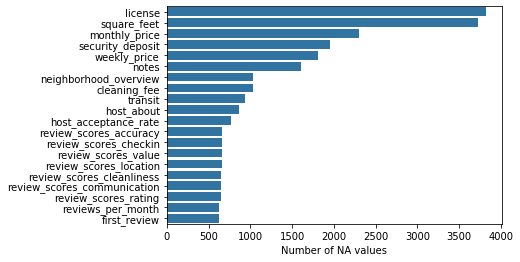

In [9]:
na_counts = dfSeattleListings.isna().sum().sort_values(ascending=False)
base_color = sns.color_palette()[0]
sns.barplot(na_counts[:20], na_counts[:20].index.values, color = base_color);
plt.xlabel('Number of NA values')

In [10]:
dfSeattleListings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

focussing on the most interesting seeming columns ("square_feet" would be interesting too but we'll drop this due to lots of missing values)

In [11]:
cols=['experiences_offered', 'host_response_time', 'host_response_rate', 
      'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
      'host_has_profile_pic', 'host_identity_verified', 'zipcode', 'property_type', 'room_type', 
      'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'number_of_reviews',
     'review_scores_rating', 'reviews_per_month']
df = dfSeattleListings[cols]
df.tail(5)

,experiences_offered,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,zipcode,...,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,number_of_reviews,review_scores_rating,reviews_per_month
3813,none,within a few hours,99%,100%,f,354.0,354.0,t,t,98107,...,Entire home/apt,6,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$359.00,1,80.0,0.3
3814,none,within an hour,100%,100%,f,1.0,1.0,t,t,98102,...,Entire home/apt,4,1.0,1.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$79.00,2,100.0,2.0
3815,none,NaN,NaN,NaN,f,1.0,1.0,t,f,98178,...,Entire home/apt,2,1.0,1.0,1.0,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ...",$93.00,0,NaN,NaN
3816,none,within an hour,100%,NaN,f,1.0,1.0,t,t,98112,...,Entire home/apt,2,1.0,0.0,1.0,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",$99.00,0,NaN,NaN
3817,none,within a day,100%,NaN,f,1.0,1.0,t,t,98109,...,Entire home/apt,3,1.5,2.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$87.00,0,NaN,NaN


## Cleaning data

First I am going to convert the non-categorical string columns to numeric columns and also convert the string-formatted Boolean columns to numerically formatted columns.

In [12]:
pd.options.mode.chained_assignment = None  # default='warn'
df['host_response_rate'] = df['host_response_rate'].astype(str)
df['host_response_rate'] = df['host_response_rate'].str.replace("%", "").astype("float")

df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace("%", "").astype("float")

df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace("[$, ]", "").astype("float")

df['host_is_superhost']=np.where(df['host_is_superhost']=='t',1,0)
df['host_has_profile_pic']=np.where(df['host_has_profile_pic']=='t',1,0)
df['host_identity_verified']=np.where(df['host_identity_verified']=='t',1,0)

In [13]:
print(df['experiences_offered'].value_counts())
#dropping "experiences_offered" since it only contains 1 value
df = df.drop(['experiences_offered'], axis=1)

none    3818
Name: experiences_offered, dtype: int64


In [14]:
#df = df.dropna(subset=['price'])   #Drop only if NaN in specific column

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 20 columns):
host_response_time           3295 non-null object
host_response_rate           3295 non-null float64
host_acceptance_rate         3045 non-null float64
host_is_superhost            3818 non-null int32
host_listings_count          3816 non-null float64
host_total_listings_count    3816 non-null float64
host_has_profile_pic         3818 non-null int32
host_identity_verified       3818 non-null int32
zipcode                      3811 non-null object
property_type                3817 non-null object
room_type                    3818 non-null object
accommodates                 3818 non-null int64
bathrooms                    3802 non-null float64
bedrooms                     3812 non-null float64
beds                         3817 non-null float64
amenities                    3818 non-null object
price                        3818 non-null float64
number_of_reviews            3818 non-n

In [16]:
print(df['amenities'].value_counts())

{}                                                                                                                                                                                                                                                                                                      45
{Internet,"Wireless Internet",Kitchen,"Free Parking on Premises",Heating,Washer,Dryer}                                                                                                                                                                                                                  11
{TV,"Cable TV",Internet,"Wireless Internet",Pool,Kitchen,"Free Parking on Premises",Gym,"Elevator in Building","Hot Tub",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Essentials,Shampoo,"24-Hour Check-in",Hangers,"Hair Dryer",Iron}    10
{TV,"Cable TV",Internet,"Wireless Internet",Kitchen,"Buzzer/Wireless Intercom",Heating,Washer,Dryer,Ess

Let's try to clean the amenities column and to convert it to something useful. I am interested if th amount of amenities has an effect on the price.


In [35]:
df['amenities_len'] = df['amenities'].apply(lambda x: len(convertAmenities(x)))
df = df.drop(['amenities'], axis=1)

Text(0, 0.5, 'Count')

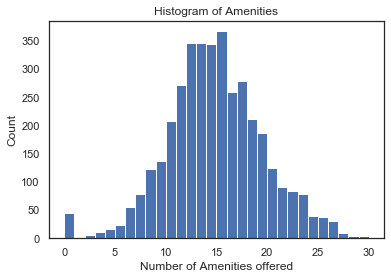

In [36]:
plt.hist(df['amenities_len'], 30)
plt.title('Histogram of Amenities')
plt.xlabel('Number of Amenities offered')
plt.ylabel('Count')

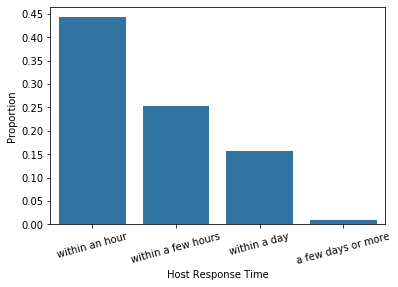

In [19]:
responseTimeClasses = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
vclasses = pd.api.types.CategoricalDtype(ordered = True, categories = responseTimeClasses)
df['host_response_time'] = df['host_response_time'].astype(vclasses)
makeCountplot(df, 'host_response_time', 'Host Response Time', 15)

Most Airbnb Hosts answer requests very quickly, almost half of them answer within an hour.

I wonder if superhosts answer even faster than normal hosts.

Text(0.5, 0, 'Host response Time')

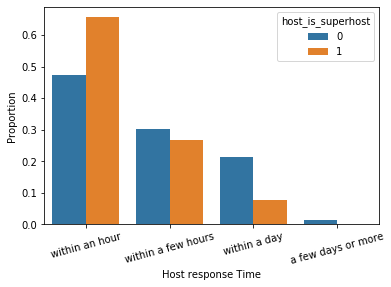

In [20]:
x, y, hue = "host_response_time", "Proportion", "host_is_superhost"

prop_df = (df[x]
           .groupby(df[hue])
           .value_counts(normalize=True)
           .rename(y)
           .reset_index())

sns.barplot(x=x, y=y, hue=hue, data=prop_df)
plt.xticks(rotation=15)
plt.xlabel('Host response Time')

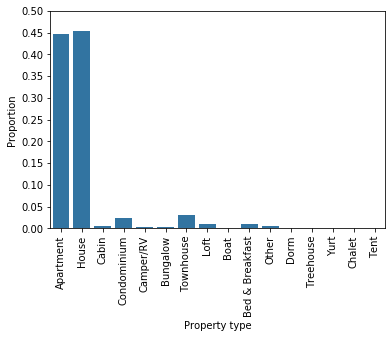

In [21]:
makeCountplot(df, 'property_type', 'Property type', 90)

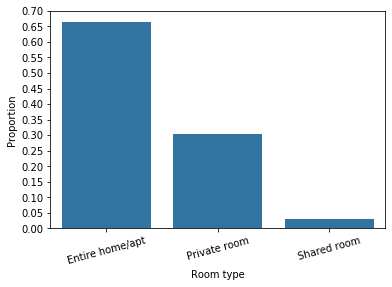

In [22]:
makeCountplot(df, 'room_type', 'Room type', 15)

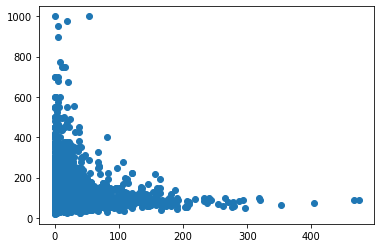

In [23]:
plt.scatter(x=df["number_of_reviews"], y=df["price"]);

Text(0, 0.5, 'Price in $')

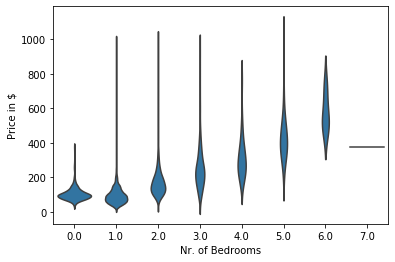

In [24]:
base_color = sns.color_palette()[0]
sns.violinplot(data = df, x = 'bedrooms', y = 'price', color = base_color,
              inner = None)
plt.xlabel('Nr. of Bedrooms')
plt.ylabel('Price in $')

There seems to be a linear relationship between the number of bedrooms and the price which comes at no surprise.

Text(0, 0.5, 'Price in $')

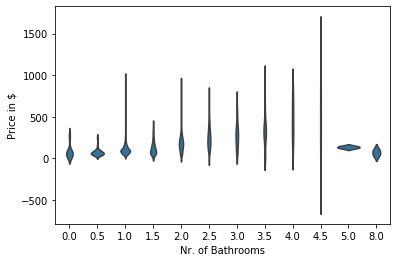

In [25]:
base_color = sns.color_palette()[0]
sns.violinplot(data = df, x = 'bathrooms', y = 'price', color = base_color,
              inner = None)
plt.xlabel('Nr. of Bathrooms')
plt.ylabel('Price in $')

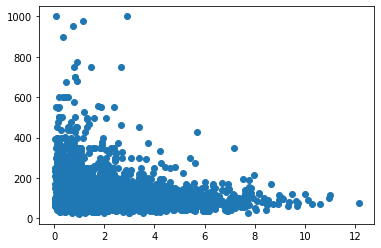

In [26]:
plt.scatter(x=df["reviews_per_month"], y=df["price"]);

(array([105., 411., 548., 627., 553., 380., 349., 183., 105., 130.,  72.,
         99.,  18.,  34.,  49.,  17.,  39.,   5.,  11.,  21.,   5.,  15.,
          2.,   4.,   9.,   1.,   1.,   6.,   1.,   4.,   0.,   0.,   0.,
          2.,   3.,   0.,   0.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   1.,   2.]),
 array([  20. ,   39.6,   59.2,   78.8,   98.4,  118. ,  137.6,  157.2,
         176.8,  196.4,  216. ,  235.6,  255.2,  274.8,  294.4,  314. ,
         333.6,  353.2,  372.8,  392.4,  412. ,  431.6,  451.2,  470.8,
         490.4,  510. ,  529.6,  549.2,  568.8,  588.4,  608. ,  627.6,
         647.2,  666.8,  686.4,  706. ,  725.6,  745.2,  764.8,  784.4,
         804. ,  823.6,  843.2,  862.8,  882.4,  902. ,  921.6,  941.2,
         960.8,  980.4, 1000. ]),
 <a list of 50 Patch objects>)

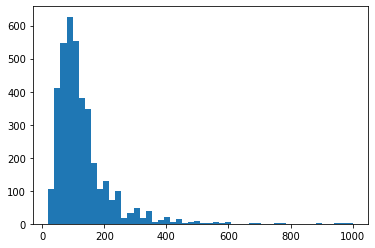

In [27]:
plt.hist(df["price"], 50)

In [28]:
df_num = df.select_dtypes(include=['number'])
df_num.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews',
       'review_scores_rating', 'reviews_per_month', 'amenities_len'],
      dtype='object')

In [29]:
df.describe()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating,reviews_per_month,amenities_len
count,3295.000000,3045.000000,3818.000000,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,3817.000000,3818.000000,3818.000000,3171.000000,3191.000000,3818.000000
mean,94.886798,99.967159,0.203772,7.157757,7.157757,0.997643,0.784966,3.349398,1.259469,1.307712,1.735394,127.976166,22.223415,94.539262,2.078919,14.358827
std,11.866705,1.812201,0.402854,28.628149,28.628149,0.048501,0.410900,1.977599,0.590369,0.883395,1.139480,90.250022,37.730892,6.606083,1.822348,4.741425
min,17.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,20.000000,0.000000,20.000000,0.020000,0.000000
25%,98.000000,100.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,75.000000,2.000000,93.000000,0.695000,11.000000
50%,100.000000,100.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,100.000000,9.000000,96.000000,1.540000,14.000000
75%,100.000000,100.000000,0.000000,3.000000,3.000000,1.000000,1.000000,4.000000,1.000000,2.000000,2.000000,150.000000,26.000000,99.000000,3.000000,17.000000
max,100.000000,100.000000,1.000000,502.000000,502.000000,1.000000,1.000000,16.000000,8.000000,7.000000,15.000000,1000.000000,474.000000,100.000000,12.150000,30.000000


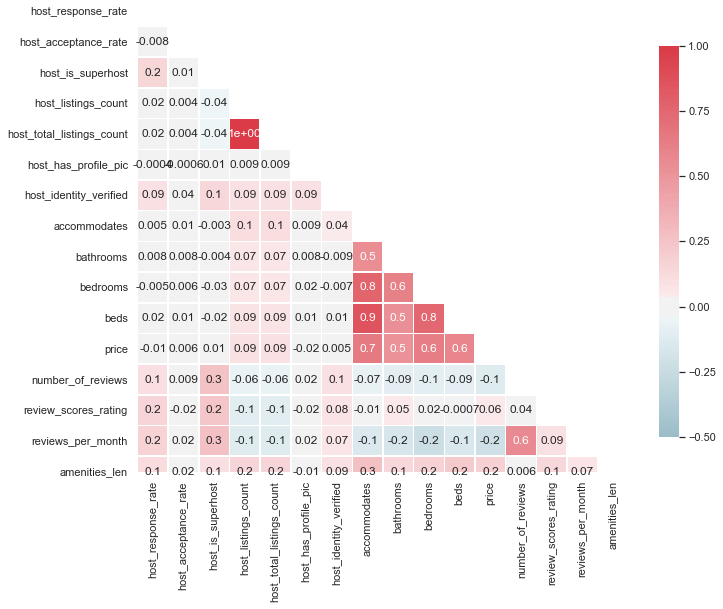

In [30]:
sns.set(style="white")

# Compute the correlation matrix 'top90', 'upto25', .drop(['scrape_id', 'license'], axis=1)
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot=True, fmt='.00')

We can clearly see that the following variables are at least moderately correllated to the price: accomodates, bathrooms, bedrooms, beds. This comes at no surprise as you would expect that bigger appartments tend to have a higher price.

To use categorical variables in a linear regression model we first have to convert them to numerical variables. So I'll create dummy variables for all categorical variables.

In [31]:
df = create_dummy_df(df, ['host_response_time', 'property_type', 'room_type', 'zipcode'], dummy_na=False)
df

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,...,zipcode_98126,zipcode_98133,zipcode_98134,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98177,zipcode_98178,zipcode_98199,zipcode_99\n98122
0,96.0,100.0,0,3.0,3.0,1,1,4,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,98.0,100.0,1,6.0,6.0,1,1,4,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,67.0,100.0,0,2.0,2.0,1,1,11,4.5,5.0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,0,1.0,1.0,1,1,3,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,100.0,NaN,0,2.0,2.0,1,1,6,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,99.0,100.0,0,354.0,354.0,1,1,6,2.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3814,100.0,100.0,0,1.0,1.0,1,1,4,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3815,NaN,NaN,0,1.0,1.0,1,0,2,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3816,100.0,NaN,0,1.0,1.0,1,1,2,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Predictive Modeling
Preparing data for Regressor

In [40]:
# Mean function
fill_mean = lambda col: col.fillna(col.mean())
# Imputing values with the mean
df[['host_response_rate', 'host_acceptance_rate']] = df[['host_response_rate', 'host_acceptance_rate']].apply(fill_mean, axis=0)

#dropping na values
df = df.dropna()

# Split into explanatory and response variables
X = df.drop('price', axis=1)
y = df['price']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

## Evaluating models

### 1. Linear Regression model

test score: 0.5568981018763124
train score: 0.6006337754217435
RMSE: 62.9684


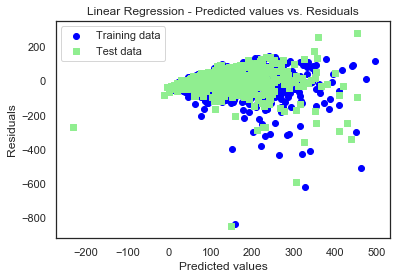

In [137]:
lm_model = LinearRegression(normalize=True)  # Instantiate
model, test_score, train_score, rmse = fitAndScoreModel(X_train, y_train, lm_model)
plotPredVsResiduals(model, 'Linear Regression')

## 2. Lasso

test score: 0.549103258569729
train score: 0.5909280177419769
RMSE: 63.5198


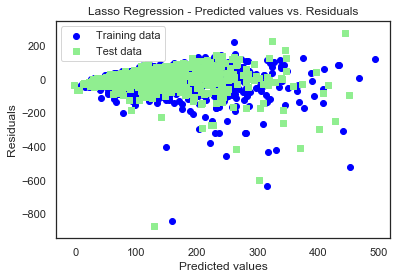

In [129]:
lassoReg = Lasso(alpha=0.1, normalize=False, random_state=42)
model, test_score, train_score, rmse = fitAndScoreModel(X_train, y_train, lassoReg)
plotPredVsResiduals(model, 'Lasso Regression')

## 3. Ridge Regression

test score: 0.5599890727848486
train score: 0.5998648416180972
RMSE: 62.7484


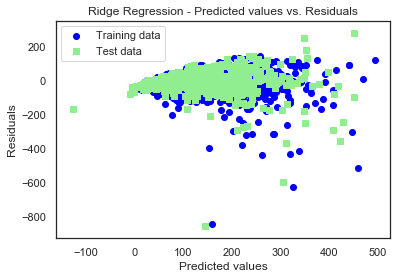

In [130]:
ridgeReg = Ridge(alpha=.5)
ridgeReg.fit(X_train, y_train)
model, test_score, train_score, rmse = fitAndScoreModel(X_train, y_train, ridgeReg)
plotPredVsResiduals(model, 'Ridge Regression')

## 4. Random Forest

test score: 0.5008580287858002
train score: 0.9454606147602865
RMSE: 66.8317


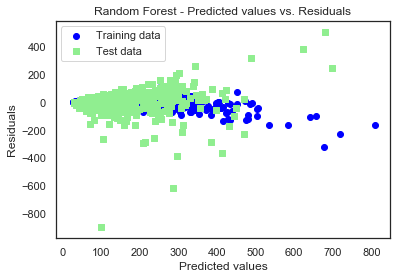

In [131]:
forest = RandomForestRegressor(n_estimators=600, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
model, test_score, train_score, rmse = fitAndScoreModel(X_train, y_train, forest)
plotPredVsResiduals(model, 'Random Forest')

The Random Forest model is clearly overfitting the train set and then performs poorly on the test set.

## 5. Gradient Boost

test score: 0.5008327533825965
train score: 0.8126129234508019
RMSE: 66.8334


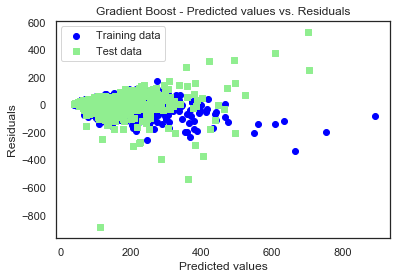

In [124]:
gbr = GradientBoostingRegressor(n_estimators=500, max_depth=4, min_samples_split=2,
          learning_rate=0.01, loss='ls')
model, test_score, train_score, rmse = fitAndScoreModel(X_train, y_train, gbr)
plotPredVsResiduals(model, 'Gradient Boost')

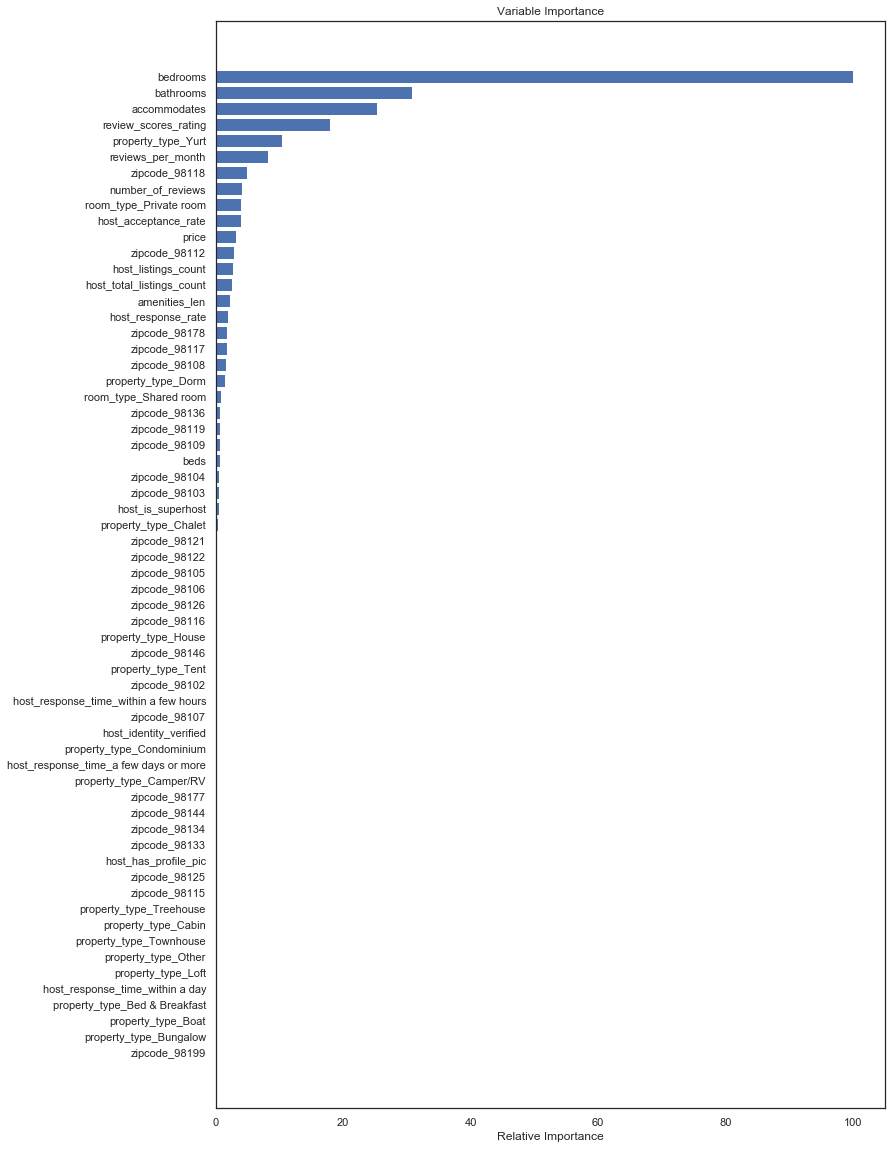

In [125]:
plotFeatureImportance(df, model)

As you can tell from the plot the number of bedrooms, bathrooms and accomodates are the most influential variable for predicting the price as these all are indicating a bigger appartment or house. But these 3 variables doesn't explain all the variance of the price. The Rating from the customer reviews also has an influence so landlords should care about making their renters stay as pleasant as possible. Some zipcodes also have an influence on the price so the location of the apartment does matter too.

Wether you are a superhost or not or if you've got your identity verified or not doesn't really impact the price of the listing.

Mögliche Fragen zu airbnb Sets:
Wie unterscheiden sich die Preise in München und Berlin?
Was hat den meisten Einfluss auf die Preisfindung?
Geben positive Reviews einen positiven Einfluss auf den Preis?